In [1]:
from IPython.display import clear_output
!pip install vit_keras
!pip install tensorflow-addons

clear_output()

In [2]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from vit_keras import vit


IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 999
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargar una parte del dataset de entrenamiento

(-0.5, 511.5, 511.5, -0.5)

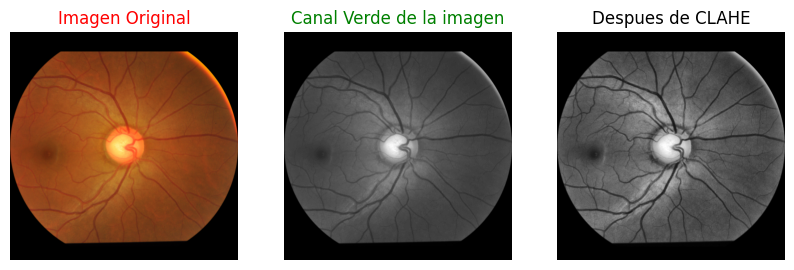

In [ ]:
normal_image = cv2.imread('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/0/BEH-180.png')
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)

green_channnel = normal_image[:,::,1] #splitting Green channel from a RGB image

clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
final_img = clahe_op.apply(green_channnel)


fig, axs = plt.subplots(1,3, figsize = (10,5), dpi = 100)

axs[0].imshow(normal_image)
axs[0].set_title('Imagen Original', color = 'red')
axs[0].axis('off')

axs[1].imshow(green_channnel, cmap = 'gray')
axs[1].set_title('Canal Verde de la imagen', color ='green')
axs[1].axis('off')

axs[2].imshow(final_img, cmap = 'gray')
axs[2].set_title('Despues de CLAHE')
axs[2].axis('off')

Creamos nuevas carpetas con estas modificaciones de las imagenes

In [ ]:
import os
base_path = '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/'

# Crear carpetas para el conjunto de entrenamiento
os.mkdir(os.path.join(base_path, 'train_converted_images'))
os.mkdir(os.path.join(base_path, 'train_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'train_converted_images', '1'))

# Crear carpetas para el conjunto de validación
os.mkdir(os.path.join(base_path, 'val_converted_images'))
os.mkdir(os.path.join(base_path, 'val_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'val_converted_images', '1'))

# Crear carpetas para el conjunto de prueba
os.mkdir(os.path.join(base_path, 'test_converted_images'))
os.mkdir(os.path.join(base_path, 'test_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'test_converted_images', '1'))

FileExistsError: [Errno 17] File exists: '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images'

Aplicamos la máscara a las imágenesyh creamos el nuevo dataset

In [ ]:
# A normal image > Green channel > Histogram Equalization

def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        #BGR images, I want to split the green channel
        img = cv2.imread(os.path.join(main_path, i))[:,::,1]
        clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
        final_img = clahe_op.apply(img)

        cv2.imwrite(os.path.join(target_path, i), final_img)

In [ ]:
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/1')

image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/1')

image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/1')

Cargar los datos

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/0')
train_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/1')

val_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/0')
val_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/1')

test_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/0')
test_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/1')


# look-up table
classes = {0: 'non-glaucoma', 1: 'glaucoma'}


train_df = pd.concat([pd.DataFrame({ 'image' : train_data_0, 'label': 0 }),
                      pd.DataFrame({ 'image' : train_data_1, 'label': 1 }) ], ignore_index = True)


val_df = pd.concat([pd.DataFrame({ 'image' : val_data_0, 'label': 0 }),
                    pd.DataFrame({ 'image' : val_data_1, 'label': 1 }) ], ignore_index = True)


test_df = pd.concat([pd.DataFrame({ 'image' : test_data_0, 'label': 0 }),
                     pd.DataFrame({ 'image' : test_data_1, 'label': 1 }) ], ignore_index = True)


train_df = shuffle(train_df, random_state = SEED).reset_index(drop = True)
val_df = shuffle(val_df, random_state = SEED).reset_index(drop = True)
test_df = shuffle(test_df, random_state = SEED).reset_index(drop = True)


# Seleccionar solo una tercera parte de los datos
train_df = train_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)
val_df = val_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)
test_df = test_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)

print("train images -> ", train_df.shape[0])
print("val images -> ", val_df.shape[0])
print("test images -> ", test_df.shape[0])

train images ->  2877
val images ->  1922
test images ->  750


Redimensinoar y Normalizar

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.3, seed = SEED)

    return img, label

# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


val_loader = tf.data.Dataset.from_tensor_slices((val_df['image'], val_df['label']))
val_dataset = (val_loader
               .map(img_preprocessing, num_parallel_calls = AUTO)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

Modelo ViT

Mi transformer vit-b16-G (especialmente para glaucoma)

Modelo ViT completo con 8 epocas

In [6]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Tesis/Proyectos2/modelos/modelo_VIT_completo8epocas.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66    

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Evaluación en el conjunto de validación
val_loss, val_acc = model.evaluate(val_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Predicciones en el conjunto de validación
val_predictions = model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Predicciones en el conjunto de prueba
test_predictions = model.predict(test_dataset)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Calcular métricas
val_accuracy = accuracy_score(val_labels, np.argmax(val_predictions, axis=1))
val_precision = precision_score(val_labels, np.argmax(val_predictions, axis=1))
val_recall = recall_score(val_labels, np.argmax(val_predictions, axis=1))
val_f1 = f1_score(val_labels, np.argmax(val_predictions, axis=1))
val_conf_matrix = confusion_matrix(val_labels, np.argmax(val_predictions, axis=1))

test_accuracy = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))
test_precision = precision_score(test_labels, np.argmax(test_predictions, axis=1))
test_recall = recall_score(test_labels, np.argmax(test_predictions, axis=1))
test_f1 = f1_score(test_labels, np.argmax(test_predictions, axis=1))
test_conf_matrix = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))

# Imprimir métricas
print('--'*50)
print("Validacion")
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

print('--'*50)
print("Prueba")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)

61/61 [==============================] - 1832s 29s/step - loss: 0.6606 - acc: 0.7170
Validation Loss: 0.6606276631355286
Validation Accuracy: 0.7169615030288696
24/24 [==============================] - 640s 26s/step - loss: 0.4265 - acc: 0.8067
Test Loss: 0.42652422189712524
Test Accuracy: 0.8066666722297668
24/24 [==============================] - 627s 26s/step
----------------------------------------------------------------------------------------------------
Validacion
Validation Accuracy: 0.7169614984391259
Validation Precision: 0.8495575221238938
Validation Recall: 0.27350427350427353
Validation F1 Score: 0.4137931034482759
Validation Confusion Matrix:
 [[1186   34]
 [ 510  192]]
----------------------------------------------------------------------------------------------------
Prueba
Test Accuracy: 0.8066666666666666
Test Precision: 0.6617647058823529
Test Recall: 0.2694610778443114
Test F1 Score: 0.3829787234042553
Test Confusion Matrix:
 [[560  23]
 [122  45]]


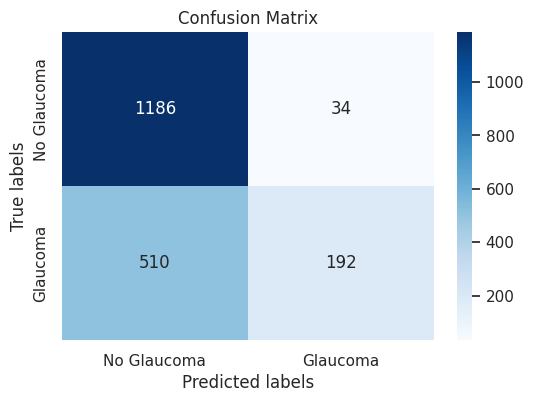

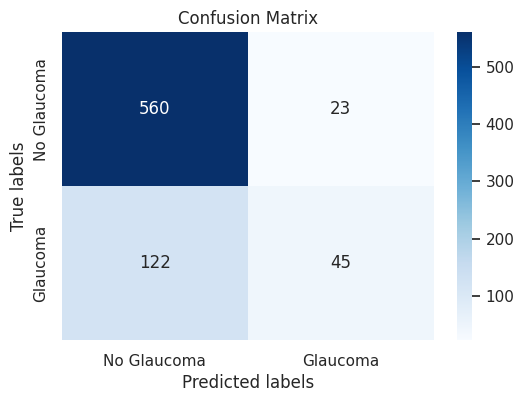

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.0)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Visualizar la matriz de confusión en el conjunto de validación
plot_confusion_matrix(val_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])

# Visualizar la matriz de confusión en el conjunto de prueba
plot_confusion_matrix(test_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])


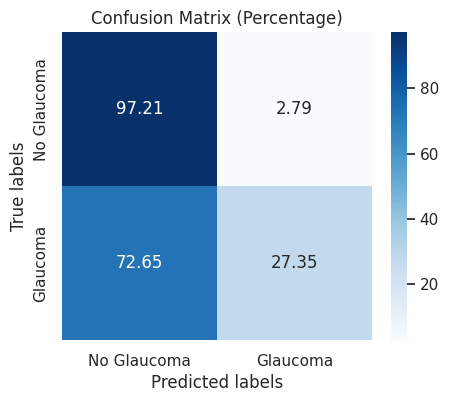

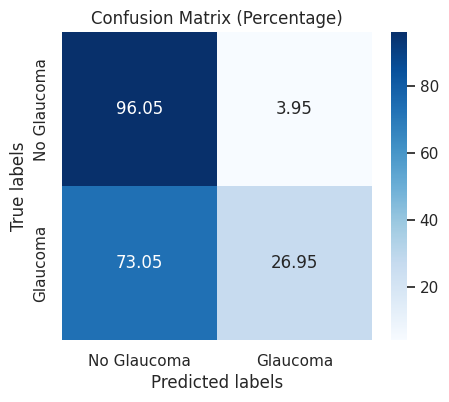

In [11]:

# Función para normalizar y visualizar la matriz de confusión
def plot_confusion_matrix(conf_matrix, labels):
    # Normalizar la matriz de confusión para obtener porcentajes
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(5, 4))
    sns.set(font_scale=1.0)
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()



# Visualizar la matriz de confusión en el conjunto de validación
plot_confusion_matrix(val_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])

# Visualizar la matriz de confusión en el conjunto de prueba
plot_confusion_matrix(test_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])